In [ ]:
!pip install datasets transformers scikit-learn seaborn plotly
!pip install streamlit pyngrok

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

print("All libraries installed successfully!")

All libraries installed successfully!


In [ ]:
print("Loading emotion dataset using alternative method...")

try:
    # Try the direct approach first
    from datasets import load_dataset
    dataset = load_dataset('dair-ai/emotion')
    print("✅ Dataset loaded successfully!")
except:
    print("Direct loading failed, trying alternative...")
    # Alternative: Load from a different source or use manual download
    dataset = load_dataset('emo')

Loading emotion dataset using alternative method...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

✅ Dataset loaded successfully!


In [ ]:
print("Dataset keys:", dataset.keys())
print("\nTrain set size:", len(dataset['train']))
print("Validation set size:", len(dataset['validation']))
print("Test set size:", len(dataset['test']))

Dataset keys: dict_keys(['train', 'validation', 'test'])

Train set size: 16000
Validation set size: 2000
Test set size: 2000


In [ ]:
print("\nFirst 3 examples:")
for i in range(3):
    print(f"Text: {dataset['train'][i]['text']}")
    print(f"Label: {dataset['train'][i]['label']}")
    print("---")


First 3 examples:
Text: i didnt feel humiliated
Label: 0
---
Text: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Label: 0
---
Text: im grabbing a minute to post i feel greedy wrong
Label: 3
---


In [ ]:
train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])
test_df = pd.DataFrame(dataset['test'])


In [ ]:
print("Dataset Info:")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Dataset Info:
Training samples: 16000
Validation samples: 2000
Test samples: 2000


In [ ]:
print("\nLabel distribution in training set:")
print(train_df['label'].value_counts().sort_index())


Label distribution in training set:
label
0    4666
1    5362
2    1304
3    2159
4    1937
5     572
Name: count, dtype: int64


In [ ]:
emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
train_df['emotion'] = train_df['label'].map(lambda x: emotion_names[x])

In [ ]:
print("\nEmotion distribution:")
print(train_df['emotion'].value_counts())


Emotion distribution:
emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


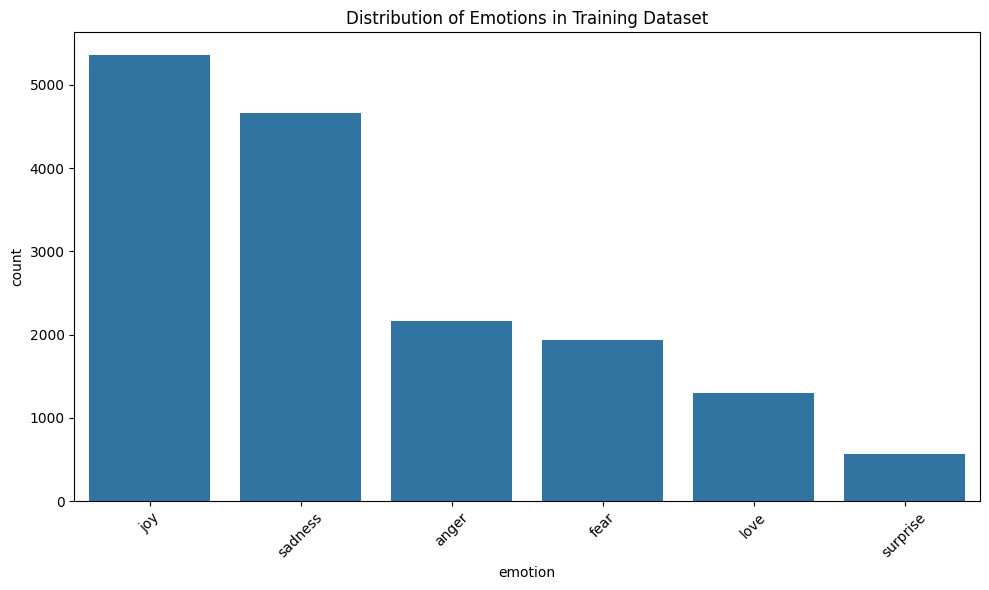

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='emotion', order=train_df['emotion'].value_counts().index)
plt.title('Distribution of Emotions in Training Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

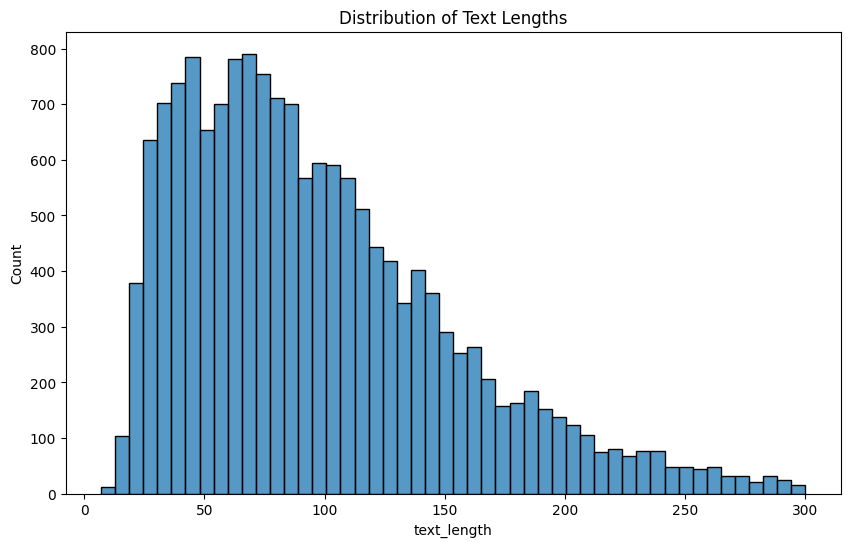

In [ ]:
train_df['text_length'] = train_df['text'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='text_length', bins=50)
plt.title('Distribution of Text Lengths')
plt.show()

In [ ]:
print(f"Average text length: {train_df['text_length'].mean():.2f}")
print(f"Max text length: {train_df['text_length'].max()}")
print(f"Min text length: {train_df['text_length'].min()}")

Average text length: 96.85
Max text length: 300
Min text length: 7


In [ ]:
print("Sample texts for each emotion:")
print("=" * 50)

for emotion in emotion_names:
    print(f"\n{emotion.upper()}:")
    emotion_samples = train_df[train_df['emotion'] == emotion]['text'].head(2)
    for i, text in enumerate(emotion_samples, 1):
        print(f"  {i}. {text}")

Sample texts for each emotion:

SADNESS:
  1. i didnt feel humiliated
  2. i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake

JOY:
  1. i have been with petronas for years i feel that petronas has performed well and made a huge profit
  2. i do feel that running is a divine experience and that i can expect to have some type of spiritual encounter

LOVE:
  1. i am ever feeling nostalgic about the fireplace i will know that it is still on the property
  2. i feel romantic too

ANGER:
  1. im grabbing a minute to post i feel greedy wrong
  2. i am feeling grouchy

FEAR:
  1. i feel as confused about life as a teenager or as jaded as a year old man
  2. i now feel compromised and skeptical of the value of every unit of work i put in

SURPRISE:
  1. ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny
  2. i have seen heard and read over the past couple of days i 

In [ ]:
combined_train = pd.concat([train_df, val_df], ignore_index=True)

In [ ]:
X_train = combined_train['text'].values
y_train = combined_train['label'].values
X_test = test_df['text'].values
y_test = test_df['label'].values

In [ ]:
print("Final dataset sizes:")
print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of emotion classes: {len(emotion_names)}")

Final dataset sizes:
Training samples: 18000
Test samples: 2000
Number of emotion classes: 6


In [ ]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [ ]:
print(f"After split - Train: {len(X_train_split)}, Validation: {len(X_val_split)}")

After split - Train: 14400, Validation: 3600


In [ ]:
# Check for any missing values or issues
print("Data Quality Check:")
print(f"Missing values in training text: {sum([1 for text in X_train if pd.isna(text) or text == ''])}")
print(f"Missing values in training labels: {sum([1 for label in y_train if pd.isna(label)])}")

# Show label distribution one more time
unique, counts = np.unique(y_train, return_counts=True)
for i, (label, count) in enumerate(zip(unique, counts)):
    print(f"Label {label} ({emotion_names[label]}): {count} samples")

print("\n✅ Phase 1 Complete! Dataset loaded and explored successfully!")
print("Ready to move to Phase 2: Preprocessing and Feature Engineering")

Data Quality Check:
Missing values in training text: 0
Missing values in training labels: 0
Label 0 (sadness): 5216 samples
Label 1 (joy): 6066 samples
Label 2 (love): 1482 samples
Label 3 (anger): 2434 samples
Label 4 (fear): 2149 samples
Label 5 (surprise): 653 samples

✅ Phase 1 Complete! Dataset loaded and explored successfully!
Ready to move to Phase 2: Preprocessing and Feature Engineering


In [ ]:
# FIXED VERSION - Cell 1: Text Preprocessing Functions (No NLTK dependency)
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS

print("Setting up text preprocessing...")

def clean_text(text):
    """Clean and preprocess text data"""
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove user mentions and hashtags (Twitter style)
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Remove extra whitespaces
    text = ' '.join(text.split())

    return text

def remove_stopwords(text):
    """Remove common English stopwords using sklearn's stopwords"""
    # Use sklearn's built-in English stopwords
    stop_words = ENGLISH_STOP_WORDS

    # Simple word tokenization (split by spaces)
    words = text.split()

    # Filter out stopwords and short words
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]

    return ' '.join(filtered_words)

# Test the preprocessing functions
sample_text = "I'm SO HAPPY today!!! 😊 This is AMAZING news! #joy @friend"
print("Original text:", sample_text)
cleaned = clean_text(sample_text)
print("Cleaned text:", cleaned)
print("Without stopwords:", remove_stopwords(cleaned))

print("✅ Preprocessing functions ready!")

Setting up text preprocessing...
Original text: I'm SO HAPPY today!!! 😊 This is AMAZING news! #joy @friend
Cleaned text: im so happy today this is amazing news
Without stopwords: happy today amazing news
✅ Preprocessing functions ready!


In [ ]:
print("Applying preprocessing to the dataset...")

# Assuming you have the dataset from Phase 1
# Convert dataset to DataFrames if not already done
if 'train_df' not in locals():
    # Convert from HuggingFace dataset format
    train_df = pd.DataFrame(dataset['train'])
    val_df = pd.DataFrame(dataset['validation']) if 'validation' in dataset else pd.DataFrame()
    test_df = pd.DataFrame(dataset['test'])

    # Combine train and validation
    if not val_df.empty:
        combined_train = pd.concat([train_df, val_df], ignore_index=True)
    else:
        combined_train = train_df

print(f"Dataset sizes - Train: {len(combined_train)}, Test: {len(test_df)}")

# Apply text cleaning
print("Cleaning training texts...")
combined_train['cleaned_text'] = combined_train['text'].apply(clean_text)
combined_train['processed_text'] = combined_train['cleaned_text'].apply(remove_stopwords)

print("Cleaning test texts...")
test_df['cleaned_text'] = test_df['text'].apply(clean_text)
test_df['processed_text'] = test_df['cleaned_text'].apply(remove_stopwords)

# Show before/after examples
print("\nBefore and After Preprocessing Examples:")
print("=" * 60)
for i in range(3):
    print(f"\nExample {i+1}:")
    print(f"Original: {combined_train.iloc[i]['text']}")
    print(f"Processed: {combined_train.iloc[i]['processed_text']}")
    print(f"Label: {combined_train.iloc[i]['label']}")

print("✅ Text preprocessing completed!")

Applying preprocessing to the dataset...
Dataset sizes - Train: 18000, Test: 2000
Cleaning training texts...
Cleaning test texts...

Before and After Preprocessing Examples:

Example 1:
Original: i didnt feel humiliated
Processed: didnt feel humiliated
Label: 0

Example 2:
Original: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Processed: feeling hopeless damned hopeful just cares awake
Label: 0

Example 3:
Original: im grabbing a minute to post i feel greedy wrong
Processed: grabbing minute post feel greedy wrong
Label: 3
✅ Text preprocessing completed!


In [ ]:
print("Creating TF-IDF features...")

# Prepare the data
X_train = combined_train['processed_text'].values
y_train = combined_train['label'].values
X_test = test_df['processed_text'].values
y_test = test_df['label'].values

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,          # Limit to top 5000 features
    ngram_range=(1, 2),         # Use unigrams and bigrams
    min_df=2,                   # Ignore terms that appear in less than 2 documents
    max_df=0.95,                # Ignore terms that appear in more than 95% of documents
    strip_accents='unicode',
    stop_words='english'
)

# Fit and transform the training data
print("Fitting TF-IDF vectorizer on training data...")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
print(f"Training set shape after TF-IDF: {X_train_tfidf.shape}")

# Transform test data
X_test_tfidf = tfidf_vectorizer.transform(X_test)
print(f"Test set shape after TF-IDF: {X_test_tfidf.shape}")

# Show some feature information
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Total features: {len(feature_names)}")
print(f"Sample features: {feature_names[:20]}")

print("✅ TF-IDF features created successfully!")

Creating TF-IDF features...
Fitting TF-IDF vectorizer on training data...
Training set shape after TF-IDF: (18000, 5000)
Test set shape after TF-IDF: (2000, 5000)
Total features: 5000
Sample features: ['abandoned' 'abilities' 'ability' 'abit' 'able' 'able feel' 'able help'
 'absolute' 'absolutely' 'abuse' 'abused' 'accept' 'acceptable'
 'acceptance' 'accepted' 'accepted allowed' 'accepting' 'access'
 'accident' 'accidentally']
✅ TF-IDF features created successfully!


In [ ]:
print("Creating train-validation split...")

# Split training data for validation
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_tfidf, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

print(f"Final dataset splits:")
print(f"  Training: {X_train_split.shape[0]} samples")
print(f"  Validation: {X_val_split.shape[0]} samples")
print(f"  Test: {X_test_tfidf.shape[0]} samples")

# Check label distribution
emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
print(f"\nLabel distribution in training split:")
unique, counts = np.unique(y_train_split, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  {emotion_names[label]}: {count} samples")

print("✅ Data preprocessing and feature engineering completed!")

Creating train-validation split...
Final dataset splits:
  Training: 14400 samples
  Validation: 3600 samples
  Test: 2000 samples

Label distribution in training split:
  sadness: 4173 samples
  joy: 4853 samples
  love: 1186 samples
  anger: 1947 samples
  fear: 1719 samples
  surprise: 522 samples
✅ Data preprocessing and feature engineering completed!


Visualizing TF-IDF features...
Top 10 TF-IDF features per emotion:

SADNESS:
   1. feel            (score: 0.0598)
   2. feeling         (score: 0.0429)
   3. like            (score: 0.0275)
   4. feel like       (score: 0.0204)
   5. just            (score: 0.0159)
   6. really          (score: 0.0125)
   7. know            (score: 0.0120)
   8. little          (score: 0.0098)
   9. ive             (score: 0.0095)
  10. bit             (score: 0.0092)

JOY:
   1. feel            (score: 0.0619)
   2. feeling         (score: 0.0379)
   3. like            (score: 0.0294)
   4. feel like       (score: 0.0226)
   5. just            (score: 0.0139)
   6. really          (score: 0.0114)
   7. time            (score: 0.0112)
   8. pretty          (score: 0.0097)
   9. good            (score: 0.0092)
  10. make            (score: 0.0090)

LOVE:
   1. feel            (score: 0.0591)
   2. like            (score: 0.0360)
   3. feeling         (score: 0.0359)
   4. feel like       (score: 0.0272

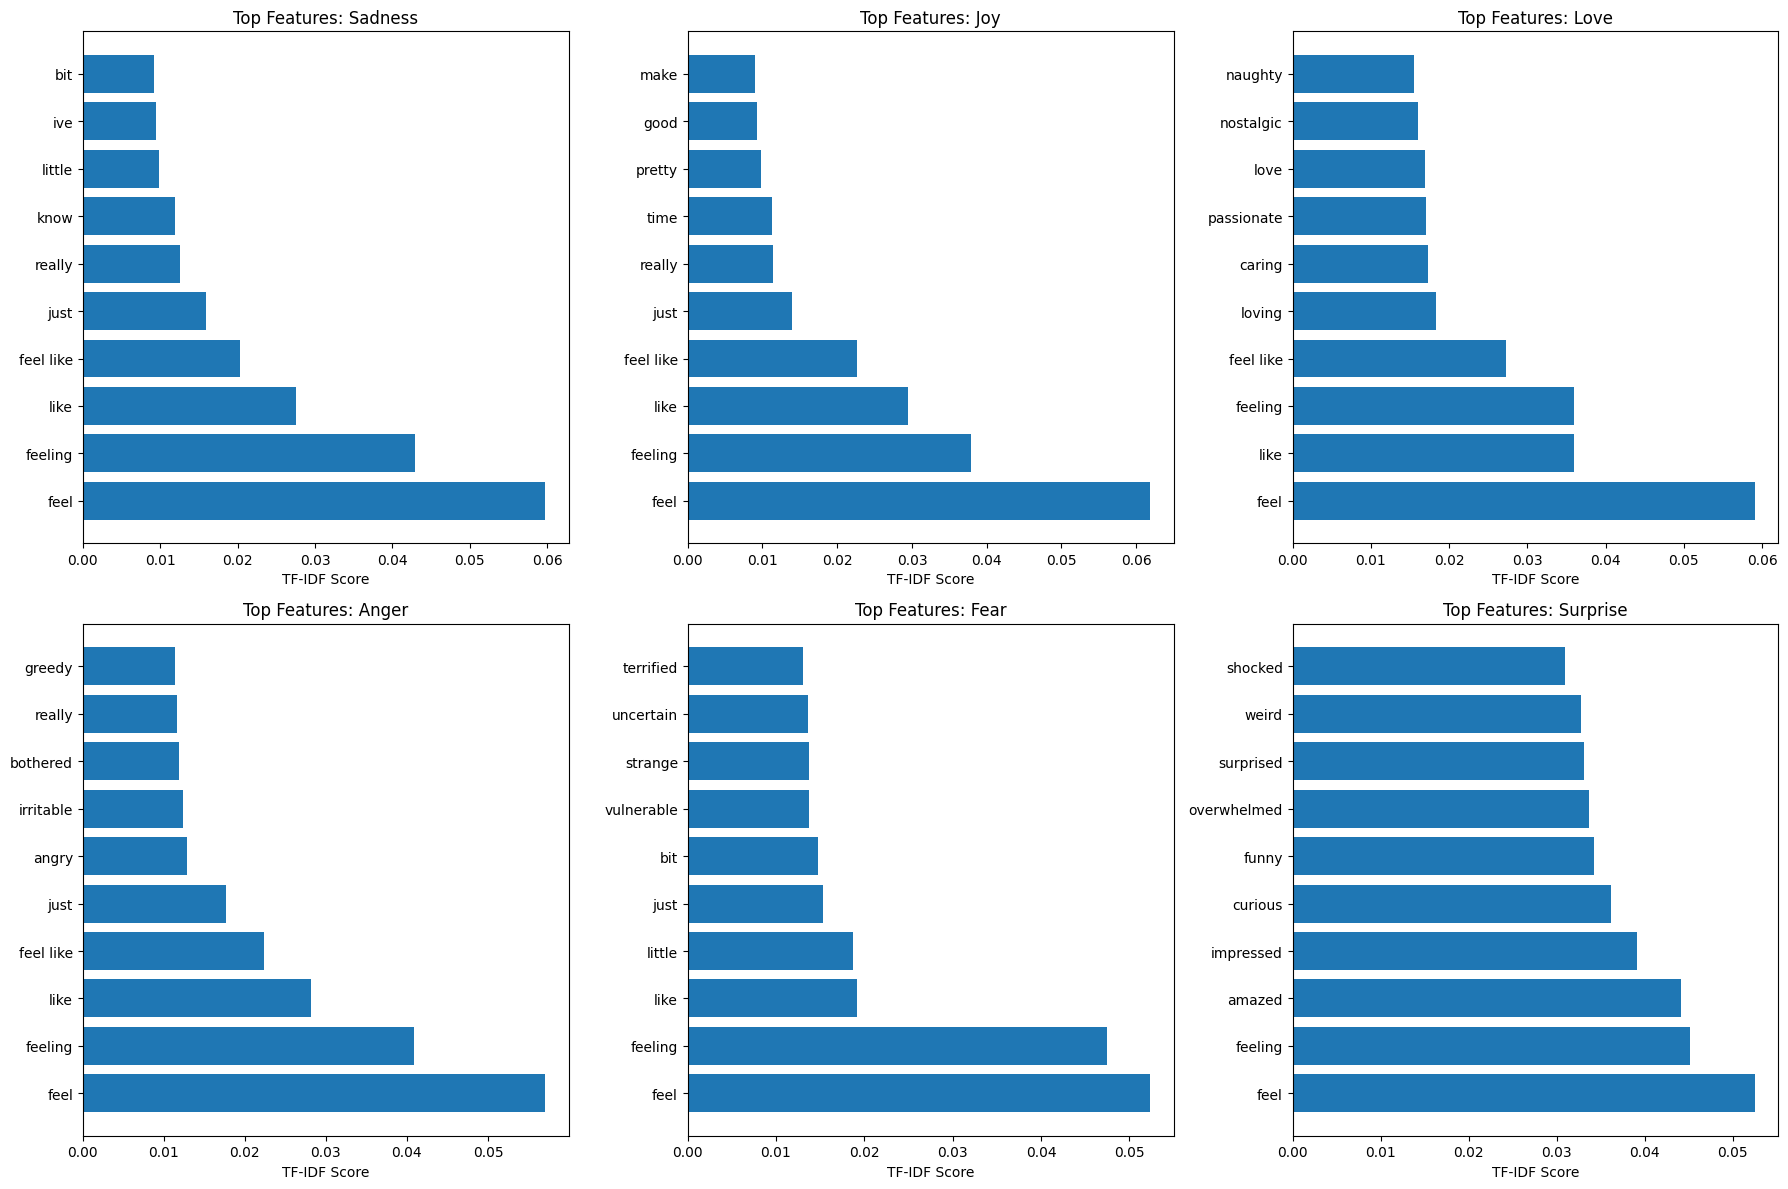

✅ Phase 2 Complete!

PHASE 2 SUMMARY:
✅ Text preprocessing completed
✅ TF-IDF features created (5000 features)
✅ Data split into train/validation/test
✅ Feature analysis completed

Ready for Phase 3: Model Training!


In [ ]:
print("Visualizing TF-IDF features...")

# Get top features for each emotion class
def get_top_features_per_class(X, y, feature_names, top_n=10):
    """Get top TF-IDF features for each emotion class"""

    results = {}

    for emotion_idx in range(len(emotion_names)):
        # Get documents for this emotion
        mask = y == emotion_idx
        if np.sum(mask) == 0:
            continue

        # Calculate mean TF-IDF scores for this emotion
        emotion_tfidf = X[mask].mean(axis=0).A1

        # Get top features
        top_indices = emotion_tfidf.argsort()[-top_n:][::-1]
        top_features = [(feature_names[i], emotion_tfidf[i]) for i in top_indices]

        results[emotion_names[emotion_idx]] = top_features

    return results

# Get top features per emotion
top_features = get_top_features_per_class(X_train_split, y_train_split, feature_names)

# Display results
print("Top 10 TF-IDF features per emotion:")
print("=" * 50)
for emotion, features in top_features.items():
    print(f"\n{emotion.upper()}:")
    for i, (feature, score) in enumerate(features, 1):
        print(f"  {i:2d}. {feature:<15} (score: {score:.4f})")

# Visualize feature importance
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, (emotion, features) in enumerate(top_features.items()):
    if idx < len(axes):
        words = [f[0] for f in features]
        scores = [f[1] for f in features]

        axes[idx].barh(range(len(words)), scores)
        axes[idx].set_yticks(range(len(words)))
        axes[idx].set_yticklabels(words)
        axes[idx].set_title(f'Top Features: {emotion.title()}')
        axes[idx].set_xlabel('TF-IDF Score')

plt.tight_layout()
plt.show()

print("✅ Phase 2 Complete!")
print("\n" + "="*60)
print("PHASE 2 SUMMARY:")
print("✅ Text preprocessing completed")
print("✅ TF-IDF features created (5000 features)")
print("✅ Data split into train/validation/test")
print("✅ Feature analysis completed")
print("\nReady for Phase 3: Model Training!")
print("="*60)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (classification_report, confusion_matrix,
                           accuracy_score, precision_recall_fscore_support)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import time

print("✅ All libraries imported for model training!")

# Emotion names for reference
emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

✅ All libraries imported for model training!


In [ ]:
print("Training multiple models...")
print("=" * 50)

# Dictionary to store models and their results
models = {}
results = {}

# 1. Logistic Regression (Baseline)
print("1. Training Logistic Regression...")
start_time = time.time()

lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    solver='liblinear'  # Good for small datasets
)
lr_model.fit(X_train_split, y_train_split)

# Predictions
lr_train_pred = lr_model.predict(X_train_split)
lr_val_pred = lr_model.predict(X_val_split)

# Store results
models['Logistic Regression'] = lr_model
results['Logistic Regression'] = {
    'train_accuracy': accuracy_score(y_train_split, lr_train_pred),
    'val_accuracy': accuracy_score(y_val_split, lr_val_pred),
    'train_time': time.time() - start_time,
    'val_predictions': lr_val_pred
}

print(f"   ✅ Completed in {results['Logistic Regression']['train_time']:.2f}s")
print(f"   Train Accuracy: {results['Logistic Regression']['train_accuracy']:.4f}")
print(f"   Val Accuracy: {results['Logistic Regression']['val_accuracy']:.4f}")

Training multiple models...
1. Training Logistic Regression...
   ✅ Completed in 0.46s
   Train Accuracy: 0.9361
   Val Accuracy: 0.8803


In [ ]:
print("\n2. Training Random Forest...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf_model.fit(X_train_split, y_train_split)

# Predictions
rf_train_pred = rf_model.predict(X_train_split)
rf_val_pred = rf_model.predict(X_val_split)

# Store results
models['Random Forest'] = rf_model
results['Random Forest'] = {
    'train_accuracy': accuracy_score(y_train_split, rf_train_pred),
    'val_accuracy': accuracy_score(y_val_split, rf_val_pred),
    'train_time': time.time() - start_time,
    'val_predictions': rf_val_pred
}

print(f"   ✅ Completed in {results['Random Forest']['train_time']:.2f}s")
print(f"   Train Accuracy: {results['Random Forest']['train_accuracy']:.4f}")
print(f"   Val Accuracy: {results['Random Forest']['val_accuracy']:.4f}")


2. Training Random Forest...
   ✅ Completed in 26.21s
   Train Accuracy: 0.9967
   Val Accuracy: 0.8950


In [ ]:
print("\n3. Training Multinomial Naive Bayes...")
start_time = time.time()

nb_model = MultinomialNB(alpha=1.0)
nb_model.fit(X_train_split, y_train_split)

# Predictions
nb_train_pred = nb_model.predict(X_train_split)
nb_val_pred = nb_model.predict(X_val_split)

# Store results
models['Naive Bayes'] = nb_model
results['Naive Bayes'] = {
    'train_accuracy': accuracy_score(y_train_split, nb_train_pred),
    'val_accuracy': accuracy_score(y_val_split, nb_val_pred),
    'train_time': time.time() - start_time,
    'val_predictions': nb_val_pred
}

print(f"   ✅ Completed in {results['Naive Bayes']['train_time']:.2f}s")
print(f"   Train Accuracy: {results['Naive Bayes']['train_accuracy']:.4f}")
print(f"   Val Accuracy: {results['Naive Bayes']['val_accuracy']:.4f}")


3. Training Multinomial Naive Bayes...
   ✅ Completed in 0.01s
   Train Accuracy: 0.8660
   Val Accuracy: 0.8078


In [ ]:
print("\n4. Training SVM (Linear)...")
start_time = time.time()

svm_model = SVC(
    kernel='linear',
    random_state=42,
    probability=True  # Enable probability predictions
)
svm_model.fit(X_train_split, y_train_split)

# Predictions
svm_train_pred = svm_model.predict(X_train_split)
svm_val_pred = svm_model.predict(X_val_split)

# Store results
models['SVM'] = svm_model
results['SVM'] = {
    'train_accuracy': accuracy_score(y_train_split, svm_train_pred),
    'val_accuracy': accuracy_score(y_val_split, svm_val_pred),
    'train_time': time.time() - start_time,
    'val_predictions': svm_val_pred
}

print(f"   ✅ Completed in {results['SVM']['train_time']:.2f}s")
print(f"   Train Accuracy: {results['SVM']['train_accuracy']:.4f}")
print(f"   Val Accuracy: {results['SVM']['val_accuracy']:.4f}")

print("\n🎉 All models trained successfully!")


4. Training SVM (Linear)...
   ✅ Completed in 141.34s
   Train Accuracy: 0.9552
   Val Accuracy: 0.8942

🎉 All models trained successfully!


Comparing model performance...

Model Performance Comparison:
              Model  Train_Accuracy  Val_Accuracy  Training_Time
      Random Forest          0.9967        0.8950        26.2109
                SVM          0.9552        0.8942       141.3370
Logistic Regression          0.9361        0.8803         0.4625
        Naive Bayes          0.8660        0.8078         0.0132


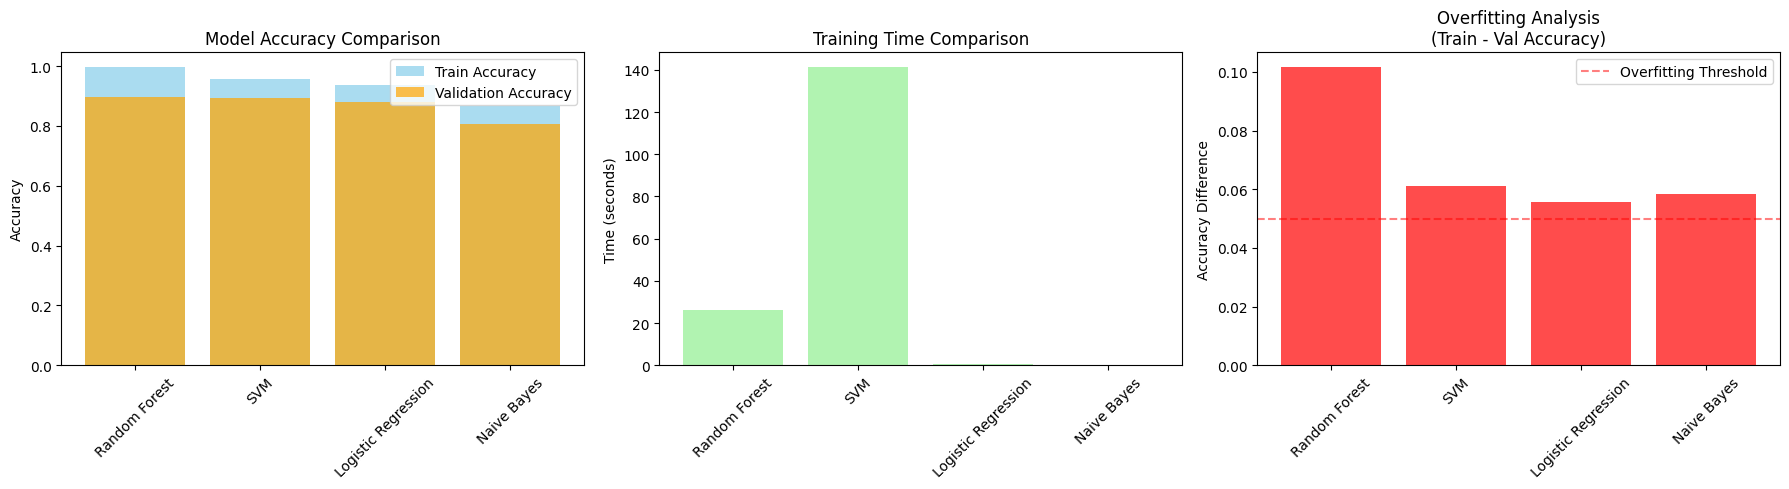


🏆 Best Model: Random Forest
   Validation Accuracy: 0.8950


In [ ]:

print("Comparing model performance...")

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train_Accuracy': [results[model]['train_accuracy'] for model in results.keys()],
    'Val_Accuracy': [results[model]['val_accuracy'] for model in results.keys()],
    'Training_Time': [results[model]['train_time'] for model in results.keys()]
})

# Sort by validation accuracy
comparison_df = comparison_df.sort_values('Val_Accuracy', ascending=False)

print("\nModel Performance Comparison:")
print("=" * 60)
print(comparison_df.to_string(index=False, float_format='%.4f'))

# Visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy comparison
axes[0].bar(comparison_df['Model'], comparison_df['Train_Accuracy'],
           alpha=0.7, label='Train Accuracy', color='skyblue')
axes[0].bar(comparison_df['Model'], comparison_df['Val_Accuracy'],
           alpha=0.7, label='Validation Accuracy', color='orange')
axes[0].set_title('Model Accuracy Comparison')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Training time comparison
axes[1].bar(comparison_df['Model'], comparison_df['Training_Time'],
           color='lightgreen', alpha=0.7)
axes[1].set_title('Training Time Comparison')
axes[1].set_ylabel('Time (seconds)')
axes[1].tick_params(axis='x', rotation=45)

# Overfitting analysis (Train - Val accuracy)
overfitting = comparison_df['Train_Accuracy'] - comparison_df['Val_Accuracy']
colors = ['red' if x > 0.05 else 'green' for x in overfitting]
axes[2].bar(comparison_df['Model'], overfitting, color=colors, alpha=0.7)
axes[2].set_title('Overfitting Analysis\n(Train - Val Accuracy)')
axes[2].set_ylabel('Accuracy Difference')
axes[2].axhline(y=0.05, color='red', linestyle='--', alpha=0.5, label='Overfitting Threshold')
axes[2].legend()
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Validation Accuracy: {comparison_df.iloc[0]['Val_Accuracy']:.4f}")

Detailed evaluation of Random Forest...

📊 Random Forest - Final Test Results:
Test Accuracy: 0.8885

Classification Report:
              precision    recall  f1-score   support

     sadness     0.9432    0.9139    0.9283       581
         joy     0.8928    0.9108    0.9017       695
        love     0.7742    0.7547    0.7643       159
       anger     0.8953    0.9018    0.8986       275
        fear     0.8613    0.9152    0.8874       224
    surprise     0.6897    0.6061    0.6452        66

    accuracy                         0.8885      2000
   macro avg     0.8427    0.8338    0.8376      2000
weighted avg     0.8881    0.8885    0.8880      2000



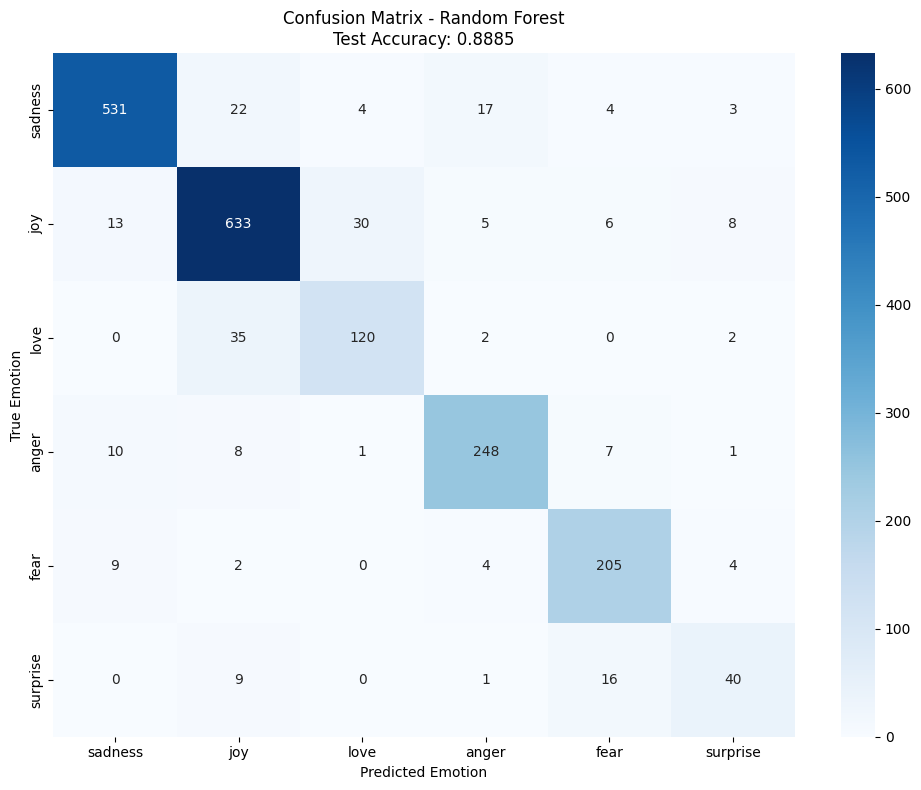


Per-Class Metrics:
 Emotion  Precision  Recall  F1-Score  Support
 sadness     0.9432  0.9139    0.9283      581
     joy     0.8928  0.9108    0.9017      695
    love     0.7742  0.7547    0.7643      159
   anger     0.8953  0.9018    0.8986      275
    fear     0.8613  0.9152    0.8874      224
surprise     0.6897  0.6061    0.6452       66


In [ ]:
print(f"Detailed evaluation of {best_model_name}...")

# Get predictions on test set
test_predictions = best_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, test_predictions)

print(f"\n📊 {best_model_name} - Final Test Results:")
print("=" * 50)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, test_predictions,
                          target_names=emotion_names,
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_names,
            yticklabels=emotion_names)
plt.title(f'Confusion Matrix - {best_model_name}\nTest Accuracy: {test_accuracy:.4f}')
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.tight_layout()
plt.show()

# Calculate per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test, test_predictions, average=None, labels=range(len(emotion_names))
)

# Create detailed metrics DataFrame
metrics_df = pd.DataFrame({
    'Emotion': emotion_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(f"\nPer-Class Metrics:")
print("=" * 60)
print(metrics_df.to_string(index=False, float_format='%.4f'))

In [ ]:
print("Performing error analysis...")

# Get test data for analysis
test_texts = test_df['text'].values
test_processed = test_df['processed_text'].values

# Find misclassified examples
misclassified_mask = test_predictions != y_test
misclassified_indices = np.where(misclassified_mask)[0]

print(f"\nError Analysis:")
print("=" * 50)
print(f"Total misclassified: {len(misclassified_indices)} out of {len(y_test)}")
print(f"Error rate: {len(misclassified_indices)/len(y_test)*100:.2f}%")

# Show some misclassified examples
print(f"\nSample Misclassified Examples:")
print("-" * 80)
for i, idx in enumerate(misclassified_indices[:5]):  # Show first 5
    true_emotion = emotion_names[y_test[idx]]
    pred_emotion = emotion_names[test_predictions[idx]]

    print(f"\nExample {i+1}:")
    print(f"Text: {test_texts[idx]}")
    print(f"True: {true_emotion} | Predicted: {pred_emotion}")

# Feature importance (for models that support it)
if hasattr(best_model, 'feature_importances_'):
    # Random Forest feature importance
    feature_importance = best_model.feature_importances_
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Get top features
    top_indices = feature_importance.argsort()[-20:][::-1]
    top_features = [(feature_names[i], feature_importance[i]) for i in top_indices]

    print(f"\nTop 20 Most Important Features ({best_model_name}):")
    print("-" * 50)
    for i, (feature, importance) in enumerate(top_features, 1):
        print(f"{i:2d}. {feature:<15} (importance: {importance:.6f})")

elif hasattr(best_model, 'coef_'):
    # Logistic Regression or SVM coefficients
    print(f"\nTop Features per Emotion Class ({best_model_name}):")
    print("-" * 60)

    feature_names = tfidf_vectorizer.get_feature_names_out()

    for i, emotion in enumerate(emotion_names):
        if len(best_model.coef_.shape) > 1:
            coefficients = best_model.coef_[i]
        else:
            coefficients = best_model.coef_

        top_indices = coefficients.argsort()[-10:][::-1]

        print(f"\n{emotion.upper()}:")
        for j, idx in enumerate(top_indices, 1):
            print(f"  {j:2d}. {feature_names[idx]:<15} (coef: {coefficients[idx]:+.4f})")

print("\n" + "="*60)
print("🎉 PHASE 3 COMPLETE!")
print("="*60)
print("✅ Multiple models trained and compared")
print("✅ Best model identified and evaluated")
print("✅ Confusion matrix and metrics calculated")
print("✅ Error analysis completed")
print(f"✅ Final Test Accuracy: {test_accuracy:.4f}")
print("\nReady for Phase 4: Building the UI!")
print("="*60)

Performing error analysis...

Error Analysis:
Total misclassified: 223 out of 2000
Error rate: 11.15%

Sample Misclassified Examples:
--------------------------------------------------------------------------------

Example 1:
Text: i felt anger when at the end of a telephone call
True: anger | Predicted: joy

Example 2:
Text: i pay attention it deepens into a feeling of being invaded and helpless
True: fear | Predicted: sadness

Example 3:
Text: i feel very honoured to be included in a magzine which prioritises health and clean living so highly im curious do any of you read magazines concerned with health and clean lifestyles such as the green parent
True: joy | Predicted: surprise

Example 4:
Text: i feel if i completely hated things i d exercise my democratic right speak my mind in what ever ways possible and try to enact a change
True: anger | Predicted: sadness

Example 5:
Text: i can t stop the anxiety i feel when i m alone when i ve got no distractions
True: sadness | Predicted:

In [38]:
!pip install streamlit pyngrok

In [39]:
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

print("✅ Streamlit and dependencies installed!")


✅ Streamlit and dependencies installed!


In [40]:
import pickle

# Save the model
with open('emotion_classifier_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save the TF-IDF vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

# Save emotion names
emotion_names = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
with open('emotion_names.pkl', 'wb') as f:
    pickle.dump(emotion_names, f)

# Save preprocessing functions as text (for the Streamlit app)
preprocessing_code = '''
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

def clean_text(text):
    """Clean and preprocess text data"""
    text = text.lower()
    text = re.sub(r'http\\S+|www\\S+|https\\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\\w+|#\\w+', '', text)
    text = re.sub(r'[^a-zA-Z\\s]', '', text)
    text = ' '.join(text.split())
    return text

def remove_stopwords(text):
    """Remove common English stopwords using sklearn's stopwords"""
    stop_words = ENGLISH_STOP_WORDS
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(filtered_words)

def preprocess_text(text):
    """Full preprocessing pipeline"""
    cleaned = clean_text(text)
    processed = remove_stopwords(cleaned)
    return processed
'''

with open('preprocessing_functions.py', 'w') as f:
    f.write(preprocessing_code)

print("✅ Model, vectorizer, and preprocessing functions saved!")

✅ Model, vectorizer, and preprocessing functions saved!


In [41]:
streamlit_app_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Import preprocessing functions
exec(open('preprocessing_functions.py').read())

# Page configuration
st.set_page_config(
    page_title="Emotion Classifier",
    page_icon="😊",
    layout="wide"
)

# Load model and components
@st.cache_resource
def load_model():
    with open('emotion_classifier_model.pkl', 'rb') as f:
        model = pickle.load(f)
    with open('tfidf_vectorizer.pkl', 'rb') as f:
        vectorizer = pickle.load(f)
    with open('emotion_names.pkl', 'rb') as f:
        emotions = pickle.load(f)
    return model, vectorizer, emotions

# Load everything
model, vectorizer, emotion_names = load_model()

# App title and description
st.title("🎭 Emotion Classification App")
st.markdown("""
### Classify text emotions with AI!
This app uses a **Random Forest** model trained on emotional text data to predict emotions from your text.
**Accuracy: 88.85%** | **6 Emotions**: Sadness, Joy, Love, Anger, Fear, Surprise
""")

# Sidebar with app info
st.sidebar.header("📊 Model Information")
st.sidebar.info(f"""
**Model Type**: Random Forest
**Training Accuracy**: 88.85%
**Features**: 5,000 TF-IDF features
**Classes**: {len(emotion_names)} emotions
""")

st.sidebar.header("🎯 How it works")
st.sidebar.markdown("""
1. **Enter text** in the input box
2. **Preprocessing** removes noise
3. **TF-IDF** converts to features
4. **Random Forest** predicts emotion
5. **Results** show probabilities
""")

# Main interface
col1, col2 = st.columns([2, 1])

with col1:
    st.header("✍️ Enter Your Text")

    # Text input
    user_text = st.text_area(
        "Type or paste your text here:",
        placeholder="Example: I am so excited about this new project!",
        height=120
    )

    # Predict button
    if st.button("🔮 Predict Emotion", type="primary"):
        if user_text.strip():
            # Preprocess text
            processed_text = preprocess_text(user_text)

            # Vectorize
            text_vector = vectorizer.transform([processed_text])

            # Predict
            prediction = model.predict(text_vector)[0]
            probabilities = model.predict_proba(text_vector)[0]

            # Display results
            st.success(f"🎯 **Predicted Emotion: {emotion_names[prediction].upper()}**")

            # Show preprocessing steps
            with st.expander("🔧 See Text Preprocessing"):
                st.write("**Original Text:**", user_text)
                st.write("**Processed Text:**", processed_text)

            # Probability visualization
            st.header("📊 Emotion Probabilities")

            # Create DataFrame for visualization
            prob_df = pd.DataFrame({
                'Emotion': emotion_names,
                'Probability': probabilities
            }).sort_values('Probability', ascending=True)

            # Horizontal bar chart
            fig = px.bar(
                prob_df,
                x='Probability',
                y='Emotion',
                orientation='h',
                color='Probability',
                color_continuous_scale='Viridis',
                title="Emotion Probability Distribution"
            )
            fig.update_layout(height=400)
            st.plotly_chart(fig, use_container_width=True)

            # Show top 3 emotions
            top_3 = prob_df.tail(3)
            st.subheader("🏆 Top 3 Emotions:")
            for i, (_, row) in enumerate(top_3.iterrows(), 1):
                st.write(f"**{i}.** {row['Emotion'].title()}: {row['Probability']:.1%}")

        else:
            st.warning("⚠️ Please enter some text to analyze!")

with col2:
    st.header("💡 Try These Examples")

    example_texts = [
        "I am so happy and excited about this opportunity!",
        "I feel really sad and disappointed about the news.",
        "This situation makes me extremely angry and frustrated!",
        "I love spending time with my family and friends.",
        "I'm terrified of what might happen next.",
        "Wow, I never expected this to happen!"
    ]

    for i, example in enumerate(example_texts):
        if st.button(f"Example {i+1}", key=f"example_{i}"):
            st.session_state.example_text = example

    # Display selected example
    if 'example_text' in st.session_state:
        st.text_area("Selected Example:", st.session_state.example_text, height=100, key="example_display")

# Footer
st.markdown("---")
st.markdown("""
<div style='text-align: center'>
    <p>🚀 Built with Streamlit | 🤖 Powered by Random Forest | 📊 88.85% Accuracy</p>
</div>
""", unsafe_allow_html=True)
'''

# Write the Streamlit app to a file
with open('emotion_app.py', 'w') as f:
    f.write(streamlit_app_code)

print("✅ Streamlit app code created!")

✅ Streamlit app code created!


In [43]:
from pyngrok import ngrok
import threading
import subprocess
import time
import os

def run_streamlit():
    """Run Streamlit app"""
    subprocess.run(["streamlit", "run", "emotion_app.py", "--server.port", "8501"])

# Get ngrok token from environment variable or set it directly
NGROK_AUTH_TOKEN =  "2yDwYbCKDwVehqLXb2jqEPse8NE_4yuSnPyENaaSSh1QQmCPp"



try:
    # Set the authentication token
    ngrok.set_auth_token(NGROK_AUTH_TOKEN)
    print("✅ Ngrok authentication set successfully!")

    # Start Streamlit in background
    print("🚀 Starting Streamlit app...")
    threading.Thread(target=run_streamlit, daemon=True).start()

    # Wait a moment for Streamlit to start
    time.sleep(5)

    # Create ngrok tunnel
    print("🔗 Creating ngrok tunnel...")
    public_url = ngrok.connect(8501)

    print("✅ Streamlit app is running!")
    print(f"🌐 Public URL: {public_url}")
    print(f"📱 You can access your app at: {public_url}")

    # Keep the script running
    print("\n⏳ Press Ctrl+C to stop the tunnel...")
    try:
        while True:
            time.sleep(1)
    except KeyboardInterrupt:
        print("\n🛑 Shutting down...")
        ngrok.disconnect(public_url)
        ngrok.kill()

except Exception as e:
    print(f"❌ Error: {e}")
    print("\n📝 Steps to fix:")
    print("1. Sign up at: https://dashboard.ngrok.com/signup")
    print("2. Get your authtoken from: https://dashboard.ngrok.com/get-started/your-authtoken")
    print("3. Set your token using one of these methods:")
    print("   - Replace 'your_authtoken_here' with your actual token")
    print("   - Set environment variable: export NGROK_AUTH_TOKEN=your_token")

✅ Ngrok authentication set successfully!
🚀 Starting Streamlit app...
🔗 Creating ngrok tunnel...
✅ Streamlit app is running!
🌐 Public URL: NgrokTunnel: "https://08a7-35-192-19-188.ngrok-free.app" -> "http://localhost:8501"
📱 You can access your app at: NgrokTunnel: "https://08a7-35-192-19-188.ngrok-free.app" -> "http://localhost:8501"

⏳ Press Ctrl+C to stop the tunnel...

🛑 Shutting down...
❌ Error: [Errno 104] Connection reset by peer

📝 Steps to fix:
1. Sign up at: https://dashboard.ngrok.com/signup
2. Get your authtoken from: https://dashboard.ngrok.com/get-started/your-authtoken
3. Set your token using one of these methods:
   - Replace 'your_authtoken_here' with your actual token
   - Set environment variable: export NGROK_AUTH_TOKEN=your_token
